# Homework 1

## FINM 35700 - Spring 2023

### UChicago Financial Mathematics

* Alex Popovici
* alex.popovici@uchicago.edu

This homework relies on:

- the US government bonds symbology file `govt_symbology`, 
- the "on-the-run" treasuries data file `govt_on_the_run`,
- the corporate  bonds symbology file `corp_symbology` and
- the market data file `market_prices_eod`.


You can find more details on US treasury instruments in the FINM 37400 Fixed Income course.



In [56]:
import QuantLib as ql
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Problem 1: Explore symbology for US treasuries and corporate bonds

## a. Load and explore US government bonds symbology data

Load the `govt_symbology` Excel file into a dataframe. For each government bond issue, calculate its initial term/time-to-maturity in years (based on issue date and maturity date), as well as the current time-to-maturity. Assume a year has 365.25 days, or use QuantLib yearFraction() function.

In [57]:
govt_symbology = pd.read_excel('../data/govt_symbology.xlsx')
govt_symbology.head()

,ticker,class,figi,isin,trace,security,name,type,coupon,cpn_type,dcc,cpn_freq,days_settle,start_date,cpn_first,acc_first,maturity,country,currency
0,B,Govt,BBG01FSQGRT9,US912796CQ02,TSRYS5551439,B 09/14/23,TREASURY BILL,US GOVERNMENT,0.0,ZERO,ACT/360,NaN,1,2023-03-16,NaT,NaT,2023-09-14,US,USD
1,B,Govt,BBG01FY3YC89,US912796CR84,TSRYS5554749,B 09/21/23,TREASURY BILL,US GOVERNMENT,0.0,ZERO,ACT/360,NaN,1,2023-03-23,NaT,NaT,2023-09-21,US,USD
2,B,Govt,BBG01G14BS72,US912796CS67,TSRYS5557561,B 09/28/23,TREASURY BILL,US GOVERNMENT,0.0,ZERO,ACT/360,NaN,1,2023-03-30,NaT,NaT,2023-09-28,US,USD
3,B,Govt,BBG01BYWNTS7,US912796CU14,TSRYS5513508,B 04/18/23,TREASURY BILL,US GOVERNMENT,0.0,ZERO,ACT/360,NaN,1,2022-12-20,NaT,NaT,2023-04-18,US,USD
4,B,Govt,BBG01C3GB4X6,US912796CV96,TSRYS5516304,B 04/25/23,TREASURY BILL,US GOVERNMENT,0.0,ZERO,ACT/360,NaN,1,2022-12-27,NaT,NaT,2023-04-25,US,USD


In [58]:
# Calculate initial term and current time-to-maturity for each bond issue
def get_symbology(df):
    for index, row in df.iterrows():
        start_date = ql.Date(row['start_date'].day, row['start_date'].month, row['start_date'].year)
        maturity_date = ql.Date(row['maturity'].day, row['maturity'].month, row['maturity'].year)
        today_date = ql.Date(14,4,2023)
        calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
        #set dcc as Actual/365.25
        dcc = ql.Actual36525()
        initial_term = dcc.yearFraction(start_date, maturity_date)
        current_time_to_maturity = dcc.yearFraction(today_date, maturity_date)
        df.at[index, 'term'] = initial_term
        df.at[index, 'TTM'] = current_time_to_maturity

    # Print the updated dataframe
    df1 = df[['ticker','figi','security','name','coupon','start_date', 'maturity', 'term', 'TTM']]
    return df1

In [59]:
govt_symbology1 = get_symbology(govt_symbology)

In [60]:
govt_symbology1

,ticker,figi,security,name,coupon,start_date,maturity,term,TTM
0,B,BBG01FSQGRT9,B 09/14/23,TREASURY BILL,0.000,2023-03-16,2023-09-14,0.498289,0.418891
1,B,BBG01FY3YC89,B 09/21/23,TREASURY BILL,0.000,2023-03-23,2023-09-21,0.498289,0.438056
2,B,BBG01G14BS72,B 09/28/23,TREASURY BILL,0.000,2023-03-30,2023-09-28,0.498289,0.457221
3,B,BBG01BYWNTS7,B 04/18/23,TREASURY BILL,0.000,2022-12-20,2023-04-18,0.325804,0.010951
4,B,BBG01C3GB4X6,B 04/25/23,TREASURY BILL,0.000,2022-12-27,2023-04-25,0.325804,0.030116
...,...,...,...,...,...,...,...,...,...
377,T,BBG01FQJ5MY4,T 4 5/8 03/15/26,US TREASURY N/B,4.625,2023-03-15,2026-03-15,3.000684,2.918549
378,T,BBG01G14BV75,T 3 5/8 03/31/30,US TREASURY N/B,3.625,2023-03-31,2030-03-31,7.000684,6.962355
379,T,BBG01G14BW91,T 3 5/8 03/31/28,US TREASURY N/B,3.625,2023-03-31,2028-03-31,5.002053,4.963723
380,T,BBG01G14BXX2,T 3 7/8 03/31/25,US TREASURY N/B,3.875,2023-03-31,2025-03-31,2.001369,1.963039


## b. Historical time series of US treasury coupons 

Plot the time series of coupons for for US treasury notes/bonds issued in the last 10 years (indexed by issue date). 
What can you say about the overall level of the coupons in the last 2 years?


In [61]:
#filter out the start dates older than 10 years from 04/14/2023
govt_symbology_plot = govt_symbology1[govt_symbology1['term'] <= 10]
#remove all the zero coupon bonds
govt_symbology_plot = govt_symbology_plot[govt_symbology_plot['coupon'] != 0]

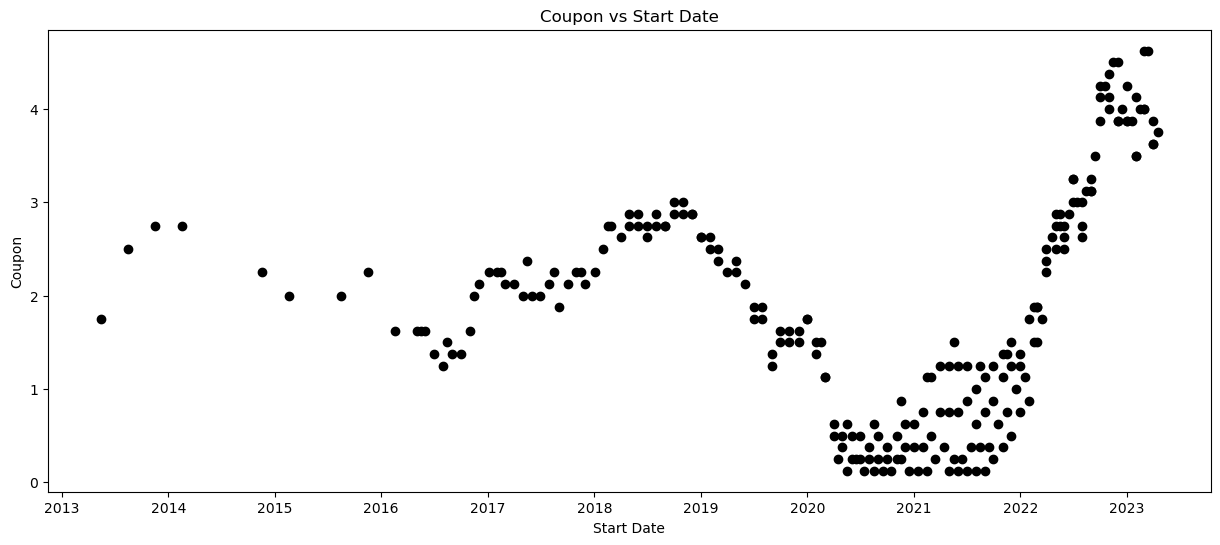

In [62]:
#create scatter plot using matplotlib
fig, ax = plt.subplots(figsize=(15, 6))
ax.scatter(govt_symbology_plot['start_date'], govt_symbology_plot['coupon'], color='black')
ax.set_xlabel('Start Date')
ax.set_ylabel('Coupon')
ax.set_title('Coupon vs Start Date')
plt.show()

> We see the coupons since 2013 (peaked around 3% in 2018) and have been declining since then.
>
> But since the beginning of 2022, the coupons have been increasing again. This is consistent with the Fed's current policy of raising interest rates.

## c. Load the on-the-run US treasuries

Load the `govt_on_the_run` Excel file into a dataframe. Select the current on-the-run 2Y, 3Y, 5Y, 7Y, 10Y, 20Y and 30Y issues (off-the-run issues have the B & C suffix). Create a separate symbology dataframe for on-the-run treasuries only, to be used later on for the on-the-run government yield curve bootstrapping.

In [63]:
gov_otr = pd.read_excel('../data/govt_on_the_run.xlsx')
gov_otr.head()

,ticker,date,isin,figi
0,GT10 Govt,2023-04-14,US91282CGM73,BBG01DVKBC66
1,GT10B Govt,2023-04-14,US91282CFV81,BBG01BC373F4
2,GT10C Govt,2023-04-14,US91282CFF32,BBG01920ZBH5
3,GT2 Govt,2023-04-14,US91282CGU99,BBG01G14BXX2
4,GT20 Govt,2023-04-14,US912810TQ13,BBG01F6N6GN1


>Removing the off-the-run issues, we are left with the following on-the-run issues:

In [64]:
#Check if the ticker has "B" or "C" in it and filter them out
gov_otr = gov_otr[~gov_otr['ticker'].str.contains('B')]
gov_otr = gov_otr[~gov_otr['ticker'].str.contains('C')]
gov_otr.reset_index(drop=True, inplace=True)

In [65]:
gov_otr

,ticker,date,isin,figi
0,GT10 Govt,2023-04-14,US91282CGM73,BBG01DVKBC66
1,GT2 Govt,2023-04-14,US91282CGU99,BBG01G14BXX2
2,GT20 Govt,2023-04-14,US912810TQ13,BBG01F6N6GN1
3,GT3 Govt,2023-04-14,US91282CGV72,BBG01G5ZMM43
4,GT30 Govt,2023-04-14,US912810TN81,BBG01DVKBH56
5,GT5 Govt,2023-04-14,US91282CGT27,BBG01G14BW91
6,GT7 Govt,2023-04-14,US91282CGS44,BBG01G14BV75


In [66]:
gov_otr_symbology = govt_symbology[govt_symbology['isin'].isin(gov_otr['isin'])]

In [67]:
gov_otr_symbology1 = get_symbology(gov_otr_symbology)
gov_otr_symbology1

,ticker,figi,security,name,coupon,start_date,maturity,term,TTM
138,T,BBG01DVKBH56,T 3 5/8 02/15/53,US TREASURY N/B,3.625,2023-02-15,2053-02-15,30.001369,29.842574
139,T,BBG01F6N6GN1,T 3 7/8 02/15/43,US TREASURY N/B,3.875,2023-02-28,2043-02-15,19.964408,19.841205
373,T,BBG01DVKBC66,T 3 1/2 02/15/33,US TREASURY N/B,3.500,2023-02-15,2033-02-15,10.001369,9.842574
378,T,BBG01G14BV75,T 3 5/8 03/31/30,US TREASURY N/B,3.625,2023-03-31,2030-03-31,7.000684,6.962355
379,T,BBG01G14BW91,T 3 5/8 03/31/28,US TREASURY N/B,3.625,2023-03-31,2028-03-31,5.002053,4.963723
380,T,BBG01G14BXX2,T 3 7/8 03/31/25,US TREASURY N/B,3.875,2023-03-31,2025-03-31,2.001369,1.963039
381,T,BBG01G5ZMM43,T 3 3/4 04/15/26,US TREASURY N/B,3.750,2023-04-17,2026-04-15,2.995209,3.003422


## d. Load and explore US corporate bonds symbology data

Load the `corp_symbology` Excel file into a dataframe. 

Create a new (filtered) dataframe for 
* bullet/non-callable (mty_typ="AT MATURITY"), 
* senior unsecured (rank = "Sr Unsecured"),
* fixed coupon (cpn_type="FIXED")

bonds only, with following columns:



| ticker | figi | security | name | coupon | start_date | maturity | term | TTM |
|----------|-------|-------------|-----|----------|---------|---------|---------|---------|

where 
* `term` refers to the initial term/time-to-maturity in years
* `TTM` refers to the current time-to-maturity in years

Create a separate dataframe for VZ issuer only.

In [68]:
corp_sym = pd.read_excel('../data/corp_symbology.xlsx')
corp_sym.head()

,ticker,class,figi,isin,trace,und_bench_isin,security,name,type,coupon,...,cpn_freq,days_settle,start_date,cpn_first,acc_first,maturity,mty_typ,rank,country,currency
0,DIS,Corp,BBG00QNKJ092,US254687CZ75,DIS4921182,US91282CGU99,DIS 3.7 09/15/24,WALT DISNEY COMPANY/THE,GLOBAL,3.700,...,2,2,2019-11-22,2020-03-15,2019-09-15,2024-09-15,CALLABLE,Sr Unsecured,US,USD
1,DIS,Corp,BBG00QNKPCL5,US254687DD54,DIS4907444,US91282CGU99,DIS 3.7 10/15/25,WALT DISNEY COMPANY/THE,GLOBAL,3.700,...,2,2,2019-11-22,2020-04-15,2019-10-15,2025-10-15,CALLABLE,Sr Unsecured,US,USD
2,DIS,Corp,BBG00QNKGJP6,US254687DK97,DIS4907439,US91282CGR60,DIS 3 3/8 11/15/26,WALT DISNEY COMPANY/THE,GLOBAL,3.375,...,2,2,2019-11-22,2020-05-15,2019-11-15,2026-11-15,CALLABLE,Sr Unsecured,US,USD
3,DIS,Corp,BBG00QNKP8R8,US254687DV52,DIS4908605,US91282CGM73,DIS 6.55 03/15/33,WALT DISNEY COMPANY/THE,GLOBAL,6.550,...,2,2,2019-11-22,2020-03-15,2019-09-15,2033-03-15,AT MATURITY,Sr Unsecured,US,USD
4,DIS,Corp,BBG00QNKR4J4,US254687DZ66,DIS4908062,US91282CGM73,DIS 6.2 12/15/34,WALT DISNEY COMPANY/THE,GLOBAL,6.200,...,2,2,2019-11-22,2019-12-15,2019-06-15,2034-12-15,AT MATURITY,Sr Unsecured,US,USD


In [69]:
corp_symbology = corp_sym[(corp_sym['mty_typ'] == 'AT MATURITY') & (corp_sym['rank'] == 'Sr Unsecured') & (corp_sym['cpn_type'] == 'FIXED')]

In [70]:
corp_symbology = get_symbology(corp_symbology)
corp_symbology

,ticker,figi,security,name,coupon,start_date,maturity,term,TTM
3,DIS,BBG00QNKP8R8,DIS 6.55 03/15/33,WALT DISNEY COMPANY/THE,6.550,2019-11-22,2033-03-15,13.311431,9.919233
4,DIS,BBG00QNKR4J4,DIS 6.2 12/15/34,WALT DISNEY COMPANY/THE,6.200,2019-11-22,2034-12-15,15.063655,11.671458
5,DIS,BBG00QNKRV04,DIS 6.4 12/15/35,WALT DISNEY COMPANY/THE,6.400,2019-11-22,2035-12-15,16.062971,12.670773
6,DIS,BBG00QNKSCY8,DIS 6.15 03/01/37,WALT DISNEY COMPANY/THE,6.150,2019-11-22,2037-03-01,17.273101,13.880903
7,DIS,BBG00QNKSBB5,DIS 6.65 11/15/37,WALT DISNEY COMPANY/THE,6.650,2019-11-22,2037-11-15,17.982204,14.590007
...,...,...,...,...,...,...,...,...,...
201,VZ,BBG00HC11V79,VZ 4 1/2 08/10/33,VERIZON COMMUNICATIONS,4.500,2017-08-10,2033-08-10,16.000000,10.324435
202,VZ,BBG00JKZK9K4,VZ 3.376 02/15/25,VERIZON COMMUNICATIONS,3.376,2018-01-19,2025-02-15,7.074606,1.842574
203,VZ,BBG00M1BQWX0,VZ 4.329 09/21/28,VERIZON COMMUNICATIONS,4.329,2018-10-22,2028-09-21,9.916496,5.440110
221,VZ,BBG00ZLKTDJ4,VZ 0 3/4 03/22/24,VERIZON COMMUNICATIONS,0.750,2021-03-22,2024-03-22,3.000684,0.939083


In [71]:
corp_symbology_VZ = corp_symbology[corp_symbology['ticker'] == 'VZ']
corp_symbology_VZ

,ticker,figi,security,name,coupon,start_date,maturity,term,TTM
181,VZ,BBG00000BHR9,VZ 6 1/4 04/01/37,VERIZON COMMUNICATIONS,6.250,2007-04-03,2037-04-01,29.995893,13.965777
182,VZ,BBG0000M1DD6,VZ 6.4 02/15/38,VERIZON COMMUNICATIONS,6.400,2008-02-12,2038-02-15,30.009582,14.841889
183,VZ,BBG0027BCJ08,VZ 4 3/4 11/01/41,VERIZON COMMUNICATIONS,4.750,2011-11-03,2041-11-01,29.995893,18.551677
185,VZ,BBG00580D503,VZ 6.4 09/15/33,VERIZON COMMUNICATIONS,6.400,2013-09-18,2033-09-15,19.991786,10.422998
186,VZ,BBG00580DD79,VZ 6.55 09/15/43,VERIZON COMMUNICATIONS,6.550,2013-09-18,2043-09-15,29.990418,20.421629
187,VZ,BBG0083CP3G1,VZ 4.862 08/21/46,VERIZON COMMUNICATIONS,4.862,2015-03-11,2046-08-21,31.446954,23.353867
188,VZ,BBG0083CP816,VZ 5.012 08/21/54,VERIZON COMMUNICATIONS,5.012,2015-03-11,2054-08-21,39.446954,31.353867
191,VZ,BBG009PNV1G8,VZ 4.272 01/15/36,VERIZON COMMUNICATIONS,4.272,2015-08-20,2036-01-15,20.405202,12.755647
192,VZ,BBG009PNW3Z2,VZ 4.522 09/15/48,VERIZON COMMUNICATIONS,4.522,2015-08-20,2048-09-15,33.073238,25.423682
193,VZ,BBG009PNW578,VZ 4.672 03/15/55,VERIZON COMMUNICATIONS,4.672,2015-08-20,2055-03-15,39.567420,31.917864


# Problem 2: Explore EOD market prices and yields

## a. Load and explore treasury market prices and yields

Load the `market_prices_eod` Excel file into a dataframe. It provides market data for US treasuries and corporate bonds of 2023-04-14.

Join the treasuries symbology dataframe with the market data, to add the following columns:


| date | bid | ask | mid | bid_yield | ask_yield | mid_yield | term | TTM |
|----------|-------|-------------|-----|----------|---------|---------|---------|---------|

Plot a graph/scatter plot of treasury mid yields by TTM.


In [105]:
md = pd.read_excel('../data/market_prices_eod.xlsx')
md

,date,class,ticker,isin,figi,bid,ask,mid_clean,mid_dirty,bid_yield,ask_yield
0,2023-04-14,Corp,DIS,US254687CZ75,BBG00QNKJ092,98.6780,98.8480,98.7630,99.1020,4.679,4.551
1,2023-04-14,Corp,DIS,US254687DD54,BBG00QNKPCL5,98.4540,98.8210,98.6370,98.6680,4.361,4.203
2,2023-04-14,Corp,DIS,US254687DK97,BBG00QNKGJP6,97.0900,97.3690,97.2300,98.6640,4.260,4.174
3,2023-04-14,Corp,DIS,US254687DV52,BBG00QNKP8R8,115.1630,115.9840,115.5740,116.1740,4.624,4.529
4,2023-04-14,Corp,DIS,US254687DZ66,BBG00QNKR4J4,112.9390,113.5860,113.2620,115.3800,4.742,4.674
...,...,...,...,...,...,...,...,...,...,...,...
592,2023-04-14,Govt,T,US91282CGR60,BBG01FQJ5MY4,102.1250,102.1563,102.1406,102.5547,3.845,3.834
593,2023-04-14,Govt,T,US91282CGS44,BBG01G14BV75,100.3750,100.4375,100.4063,100.5742,3.563,3.553
594,2023-04-14,Govt,T,US91282CGT27,BBG01G14BW91,100.0703,100.0859,100.0781,100.2461,3.609,3.606
595,2023-04-14,Govt,T,US91282CGU99,BBG01G14BXX2,99.5703,99.5820,99.5762,99.7559,4.105,4.099


In [106]:
#merge the govt_symbology1 with the market data (md) on figi
govt_symbology_md = pd.merge(govt_symbology1, md, on='figi', how='inner')
#change mid_clean column name to "mid"
govt_symbology_md.rename(columns={'mid_clean': 'mid'}, inplace=True)
govt_symbology_md

,ticker_x,figi,security,name,coupon,start_date,maturity,term,TTM,date,class,ticker_y,isin,bid,ask,mid,mid_dirty,bid_yield,ask_yield
0,T,BBG000DLJF04,T 6 1/4 08/15/23,US TREASURY N/B,6.250,1993-08-16,2023-08-15,29.995893,0.336756,2023-04-14,Govt,T,US912810EQ77,100.4375,100.8750,100.6563,101.7090,4.858,3.542
1,T,BBG000DKZWK9,T 7 1/2 11/15/24,US TREASURY N/B,7.500,1994-08-15,2024-11-15,30.253251,1.590691,2023-04-14,Govt,T,US912810ES34,104.7695,105.2148,104.9922,108.1621,4.336,4.051
2,T,BBG000DLBVY0,T 7 5/8 02/15/25,US TREASURY N/B,7.625,1995-02-15,2025-02-15,30.001369,1.842574,2023-04-14,Govt,T,US912810ET17,105.9258,106.3477,106.1367,107.4219,4.224,3.992
3,T,BBG000DQQNJ8,T 6 7/8 08/15/25,US TREASURY N/B,6.875,1995-08-15,2025-08-15,30.001369,2.338125,2023-04-14,Govt,T,US912810EV62,106.2578,106.9297,106.5938,107.7520,4.032,3.740
4,T,BBG000DPXMD0,T 6 02/15/26,US TREASURY N/B,6.000,1996-02-15,2026-02-15,30.001369,2.841889,2023-04-14,Govt,T,US912810EW46,105.4453,106.0547,105.7500,106.7617,3.946,3.725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,T,BBG01FQJ5MY4,T 4 5/8 03/15/26,US TREASURY N/B,4.625,2023-03-15,2026-03-15,3.000684,2.918549,2023-04-14,Govt,T,US91282CGR60,102.1250,102.1563,102.1406,102.5547,3.845,3.834
328,T,BBG01G14BV75,T 3 5/8 03/31/30,US TREASURY N/B,3.625,2023-03-31,2030-03-31,7.000684,6.962355,2023-04-14,Govt,T,US91282CGS44,100.3750,100.4375,100.4063,100.5742,3.563,3.553
329,T,BBG01G14BW91,T 3 5/8 03/31/28,US TREASURY N/B,3.625,2023-03-31,2028-03-31,5.002053,4.963723,2023-04-14,Govt,T,US91282CGT27,100.0703,100.0859,100.0781,100.2461,3.609,3.606
330,T,BBG01G14BXX2,T 3 7/8 03/31/25,US TREASURY N/B,3.875,2023-03-31,2025-03-31,2.001369,1.963039,2023-04-14,Govt,T,US91282CGU99,99.5703,99.5820,99.5762,99.7559,4.105,4.099


>Since the mid yields are not given, we calculate the mid yields using the mid price quoted.
>
>We will use the quoted clean price to calculate YTM, but the argument could also be made to use the dirty price.

In [107]:
#functinalize above codes to get the implied yield from the mid price
def get_mid_yield(df):
    for index, row in df.iterrows():
        issue_date = ql.Date(row['start_date'].day, row['start_date'].month, row['start_date'].year)
        settle_date = ql.Date(row['maturity'].day, row['maturity'].month, row['maturity'].year)
        coupon_freq = ql.Semiannual
        coupon_term = ql.Period(coupon_freq)
        calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
        day_counter = ql.Unadjusted
        date_generation = ql.DateGeneration.Backward
        month_end = False

        schedule = ql.Schedule(issue_date,
                               settle_date,
                               coupon_term,
                               calendar,
                               day_counter,
                               day_counter,
                               date_generation,
                               month_end)

        calc_date = ql.Date(14, 4, 2023)
        ql.Settings.instance().evaluationDate = calc_date

        coupon_rate = row['coupon']/100
        day_count = ql.Thirty360(ql.Thirty360.USA)
        coupons = [coupon_rate]

        settlement_days = 1
        face_value = 100

        fixed_rate_bond = ql.FixedRateBond(
            settlement_days,
            face_value,
            schedule,
            coupons,
            day_count)

        bp1 = row['mid']
        compounding = ql.Compounded

        settle_date = fixed_rate_bond.settlementDate(calc_date)
        day_count = fixed_rate_bond.dayCounter()

        implied_yield = fixed_rate_bond.bondYield(bp1, day_count, compounding, coupon_freq, settle_date) * 100
        df.at[index, 'mid_yield'] = implied_yield
    return df

In [108]:
govt_symbology_md1 = get_mid_yield(govt_symbology_md)

In [109]:
# keep only the columns we need | date | bid | ask | mid | bid_yield | ask_yield | mid_yield | term | TTM | in govt_symbology_md1
govt_symbology_md2 = govt_symbology_md1[['date', 'bid', 'ask', 'mid', 'bid_yield', 'ask_yield', 'mid_yield', 'term', 'TTM']]

In [110]:
#sort mid_yield in ascending order
govt_symbology_md2.sort_values(by=['mid_yield'], inplace=True)
#drop the rows with mid_yield = 0
govt_symbology_md2 = govt_symbology_md2[govt_symbology_md2['mid_yield'] != 0]
#drop the rows with mid_yield = NaN
govt_symbology_md2 = govt_symbology_md2.dropna(subset=['mid_yield'])
#reset index
govt_symbology_md2.reset_index(drop=True, inplace=True)

In [111]:
govt_symbology_md2

,date,bid,ask,mid,bid_yield,ask_yield,mid_yield,term,TTM
0,2023-04-14,86.9219,86.9844,86.9531,3.497,3.488,3.357337,9.993155,8.084873
1,2023-04-14,110.7813,111.0938,110.9375,3.452,3.424,3.437713,29.998631,12.840520
2,2023-04-14,84.1719,84.2344,84.2031,3.448,3.438,3.440780,9.995893,7.841205
3,2023-04-14,82.8281,82.8906,82.8594,3.472,3.461,3.466356,9.995893,7.589322
4,2023-04-14,113.6250,113.9375,113.7813,3.499,3.472,3.483808,30.001369,13.842574
...,...,...,...,...,...,...,...,...,...
326,2023-04-14,96.8984,96.9766,96.9375,4.924,4.819,4.891896,1.998631,0.799452
327,2023-04-14,98.6758,98.7461,98.7109,5.016,4.820,4.907773,6.997947,0.380561
328,2023-04-14,98.9219,98.9961,98.9590,5.008,4.746,4.952487,6.995209,0.295688
329,2023-04-14,98.3906,98.4766,98.4336,5.060,4.793,5.002103,2.992471,0.336756


## b. Explore on-the-run treasuries only
Create a separate joint dataframe for on-the-run treasuries only.

Plot a graph/scatter plot of on-the-run treasury mid yields by TTM.

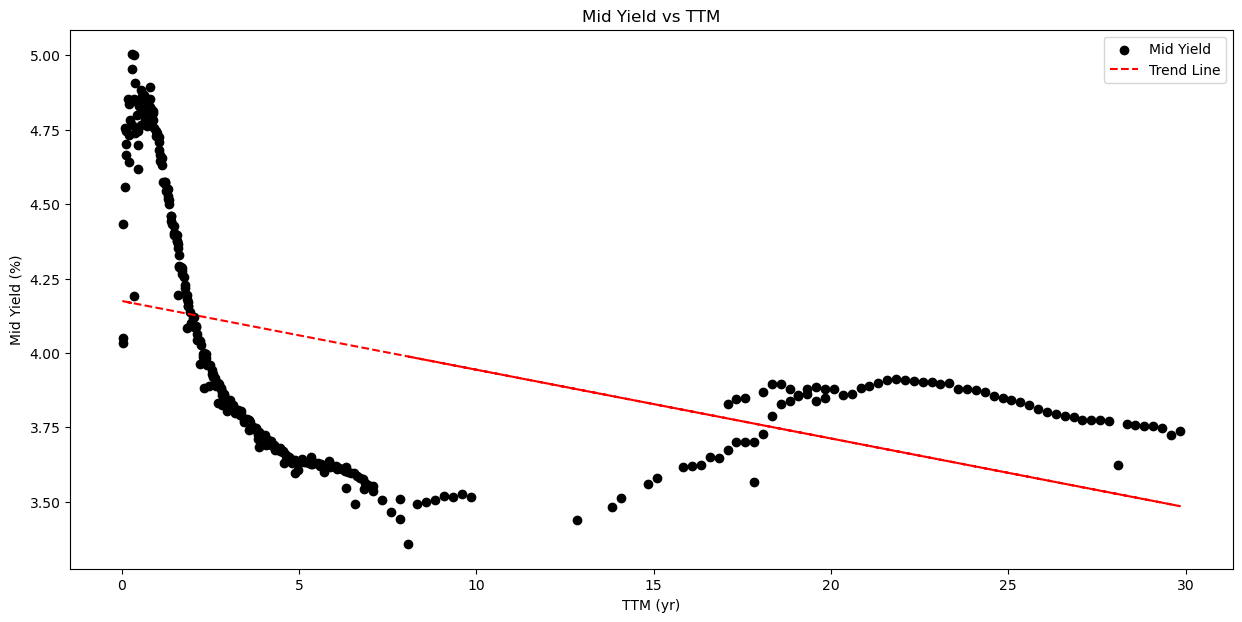

In [119]:
#scatter plot of OTR treasury mid_yield vs TTM
fig, ax = plt.subplots(figsize=(15, 7))
ax.scatter(govt_symbology_md2['TTM'], govt_symbology_md2['mid_yield'], color='black')
#add best fit line
z = np.polyfit(govt_symbology_md2['TTM'], govt_symbology_md2['mid_yield'], 1)
p = np.poly1d(z)
plt.plot(govt_symbology_md2['TTM'], p(govt_symbology_md2['TTM']), "r--")
ax.set_xlabel('TTM (yr)')
ax.set_ylabel('Mid Yield (%)')
ax.set_title('Mid Yield vs TTM')
plt.legend(['Mid Yield','Trend Line'])
plt.show()

## c. Load and explore corporate bond market prices and yields

Join the filtered corporate bonds symbology dataframe with the market data, to add the following columns:


| date | bid | ask | mid | bid_yield | ask_yield | mid_yield | term | TTM |
|----------|-------|-------------|-----|----------|---------|---------|---------|---------|

List the unique tickers/issuers available in the dataframe.

In [145]:
#merge the corp_symbology with the market data (md) on figi
corp_symbology_md = pd.merge(corp_symbology, md, on='figi', how='inner')
#change mid_clean column name to "mid" & rename "ticker_x" to "ticker"
corp_symbology_md.rename(columns={'mid_clean': 'mid', 'ticker_x': 'ticker'}, inplace=True)
#drop "ticker_y" column
corp_symbology_md.drop(columns=['ticker_y'], inplace=True)
corp_symbology_md

,ticker,figi,security,name,coupon,start_date,maturity,term,TTM,date,class,isin,bid,ask,mid,mid_dirty,bid_yield,ask_yield
0,DIS,BBG00QNKP8R8,DIS 6.55 03/15/33,WALT DISNEY COMPANY/THE,6.550,2019-11-22,2033-03-15,13.311431,9.919233,2023-04-14,Corp,US254687DV52,115.163,115.984,115.574,116.174,4.624,4.529
1,DIS,BBG00QNKR4J4,DIS 6.2 12/15/34,WALT DISNEY COMPANY/THE,6.200,2019-11-22,2034-12-15,15.063655,11.671458,2023-04-14,Corp,US254687DZ66,112.939,113.586,113.262,115.380,4.742,4.674
2,DIS,BBG00QNKRV04,DIS 6.4 12/15/35,WALT DISNEY COMPANY/THE,6.400,2019-11-22,2035-12-15,16.062971,12.670773,2023-04-14,Corp,US254687EB89,114.645,115.438,115.042,117.229,4.838,4.761
3,DIS,BBG00QNKSCY8,DIS 6.15 03/01/37,WALT DISNEY COMPANY/THE,6.150,2019-11-22,2037-03-01,17.273101,13.880903,2023-04-14,Corp,US254687EF93,111.153,112.380,111.767,112.570,5.023,4.908
4,DIS,BBG00QNKSBB5,DIS 6.65 11/15/37,WALT DISNEY COMPANY/THE,6.650,2019-11-22,2037-11-15,17.982204,14.590007,2023-04-14,Corp,US254687EH59,118.135,119.168,118.652,121.478,4.895,4.805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,VZ,BBG00HC11V79,VZ 4 1/2 08/10/33,VERIZON COMMUNICATIONS,4.500,2017-08-10,2033-08-10,16.000000,10.324435,2023-04-14,Corp,US92343VEA89,96.081,96.791,96.436,97.286,4.990,4.899
84,VZ,BBG00JKZK9K4,VZ 3.376 02/15/25,VERIZON COMMUNICATIONS,3.376,2018-01-19,2025-02-15,7.074606,1.842574,2023-04-14,Corp,US92343VEN01,97.932,98.164,98.048,98.639,4.567,4.432
85,VZ,BBG00M1BQWX0,VZ 4.329 09/21/28,VERIZON COMMUNICATIONS,4.329,2018-10-22,2028-09-21,9.916496,5.440110,2023-04-14,Corp,US92343VER15,98.655,99.025,98.840,99.165,4.611,4.533
86,VZ,BBG00ZLKTDJ4,VZ 0 3/4 03/22/24,VERIZON COMMUNICATIONS,0.750,2021-03-22,2024-03-22,3.000684,0.939083,2023-04-14,Corp,US92343VGF58,95.975,96.327,96.151,96.205,5.251,4.846


In [146]:
#prin the unirque tickers in corp_symbology_md
corp_symbology_md['ticker'].unique()

array(['DIS', 'IBM', 'MS', 'ORCL', 'VZ'], dtype=object)

>We have five companies with bonds in the given dataframe.

In [147]:
#Use the function get_mid_yield to get the implied yield from the mid price
corp_symbology_md1 = get_mid_yield(corp_symbology_md)

In [148]:
# keep only the columns we need | date | bid | ask | mid | bid_yield | ask_yield | mid_yield | term | TTM | in corp_symbology_md1
corp_symbology_md2 = corp_symbology_md1[['ticker','date', 'bid', 'ask', 'mid', 'bid_yield', 'ask_yield', 'mid_yield', 'term', 'TTM']]

In [149]:
#sort mid_yield in ascending order
corp_symbology_md2.sort_values(by=['mid_yield'], inplace=True)
#drop the rows with mid_yield = 0
corp_symbology_md2 = corp_symbology_md2[corp_symbology_md2['mid_yield'] != 0]
#drop the rows with mid_yield = NaN
corp_symbology_md2 = corp_symbology_md2.dropna(subset=['mid_yield'])
#sort TTM in ascending order
corp_symbology_md2.sort_values(by=['TTM'], inplace=True)
#reset index
corp_symbology_md2.reset_index(drop=True, inplace=True)

In [150]:
corp_symbology_md2

,ticker,date,bid,ask,mid,bid_yield,ask_yield,mid_yield,term,TTM
0,DIS,2023-04-14,100.087,100.179,100.133,4.760,0.793,3.434555,4.101300,0.032854
1,MS,2023-04-14,99.685,99.779,99.732,5.561,4.973,5.284774,9.971253,0.169747
2,ORCL,2023-04-14,99.568,99.825,99.697,5.385,4.316,4.754907,9.995893,0.251882
3,IBM,2023-04-14,99.443,99.709,99.576,5.313,4.373,4.853343,9.998631,0.298426
4,DIS,2023-04-14,101.739,102.165,101.952,5.354,4.782,5.040122,4.837782,0.769336
...,...,...,...,...,...,...,...,...,...,...
83,VZ,2023-04-14,94.636,95.983,95.309,5.367,5.275,5.320391,39.446954,31.353867
84,VZ,2023-04-14,89.255,90.454,89.855,5.380,5.295,5.336722,39.567420,31.917864
85,DIS,2023-04-14,131.152,134.810,132.981,6.003,5.836,5.918228,76.700890,72.632444
86,DIS,2023-04-14,134.389,136.554,135.471,6.120,6.021,6.069586,77.579740,73.511294


## d. Yield curve plots

Plot a graph/scatter plot of mid yield curves by TTM (one line per ticker/issuer).

Add a separate line for on-the-run US treasury yield curve (risk free curve).

What can you say about the credit issuer yields, compared to US treasury yields?

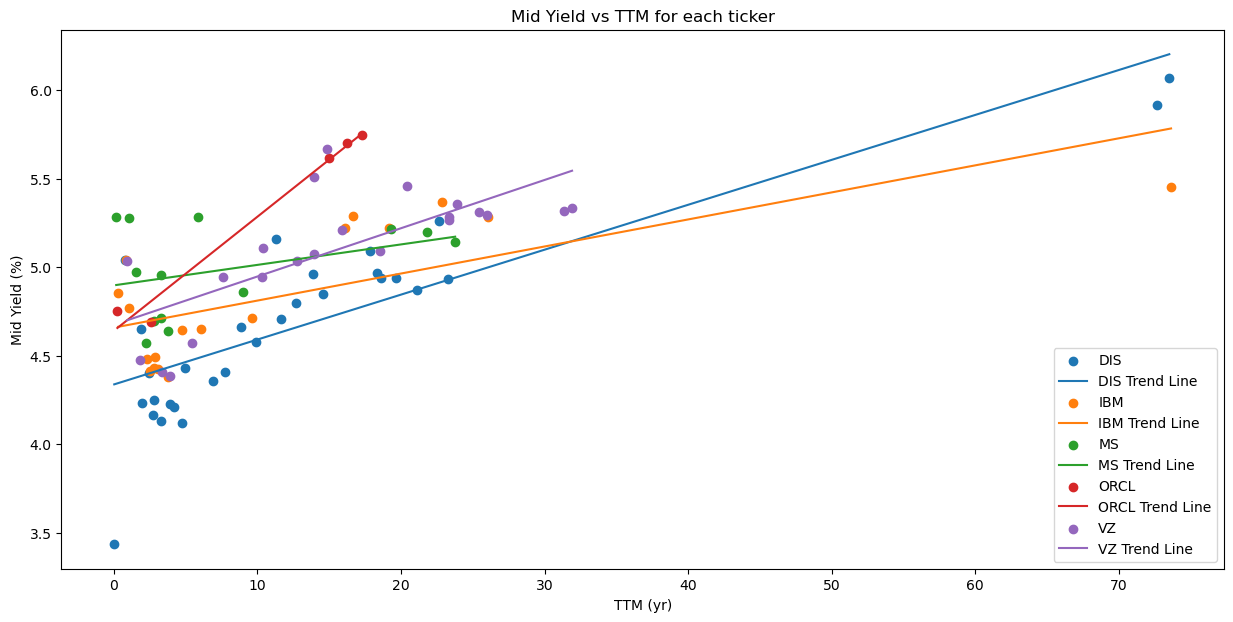

In [159]:
#Plot a graph/scatter plot of mid yield curves by TTM (one line per ticker/issuer).
#group by the data by ticker and plot the mid_yield vs TTM for each ticker
fig, ax = plt.subplots(figsize=(15, 7))
for ticker, group in corp_symbology_md2.groupby('ticker'):
    ax.scatter(group['TTM'], group['mid_yield'], label=ticker)
    #add best fit line
    z = np.polyfit(group['TTM'], group['mid_yield'], 1)
    p = np.poly1d(z)
    plt.plot(group['TTM'], p(group['TTM']), label = f'{ticker} Trend Line')
ax.set_xlabel('TTM (yr)')
ax.set_ylabel('Mid Yield (%)')
ax.set_title('Mid Yield vs TTM for each ticker')
plt.legend()
plt.show()

#### Another plot with the corporate bonds yields and the on-the-run treasury yields dropping the long end 70 yr corporate bonds for better visualization.

In [162]:
#drop TTM > 35
corp_symbology_md3 = corp_symbology_md2[corp_symbology_md2['TTM'] <= 35]

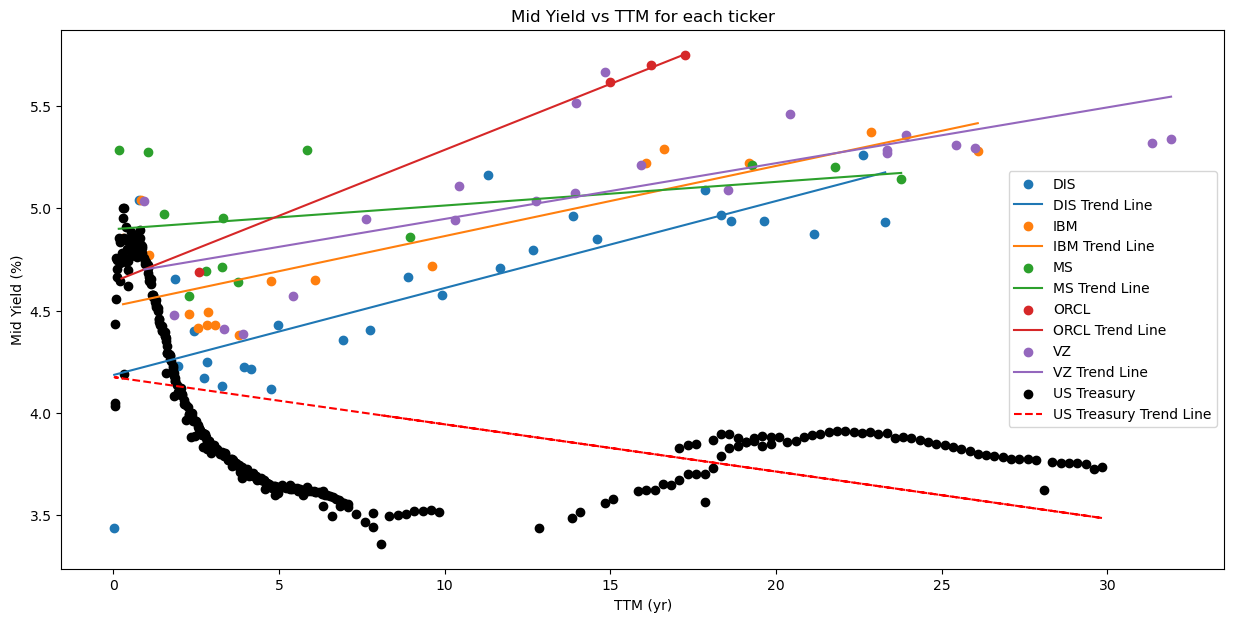

In [165]:
fig, ax = plt.subplots(figsize=(15, 7))
for ticker, group in corp_symbology_md3.groupby('ticker'):
    ax.scatter(group['TTM'], group['mid_yield'], label=ticker)
    #add best fit line
    z = np.polyfit(group['TTM'], group['mid_yield'], 1)
    p = np.poly1d(z)
    plt.plot(group['TTM'], p(group['TTM']), label = f'{ticker} Trend Line')
#add us treasury mid_yield vs TTM
ax.scatter(govt_symbology_md2['TTM'], govt_symbology_md2['mid_yield'], color='black', label='US Treasury')
#add best fit line
z = np.polyfit(govt_symbology_md2['TTM'], govt_symbology_md2['mid_yield'], 1)
p = np.poly1d(z)
plt.plot(govt_symbology_md2['TTM'], p(govt_symbology_md2['TTM']), "r--", label='US Treasury Trend Line')
ax.set_xlabel('TTM (yr)')
ax.set_ylabel('Mid Yield (%)')
ax.set_title('Mid Yield vs TTM for each ticker')
plt.legend()
plt.show()

# Problem 3: Underying treasury benchmarks and credit spreads

## a. Add underlying benchmark bond mid yields

Use the column 'und_bench_yield' to identify the underlying benchmark bond for each issue.

Add two new columns to the joint corporate bond dataframe:

| und_bench_yield | credit_spread |
|----------|-------|

where 

*  `und_bench_yield` = underlying benchmark bond mid yield and
*  `credit_spread` = issue yield - underlying benchmark bond mid yield.

## b. Credit spread curve plots

Plot a graph/scatter plot of credit spread curves by TTM (one line per issuer).


## c. Add g-spreads

Add two new columns to the joint corporate bond dataframe:

| interp_tsy_yield | g_spread |
|----------|-------|

where 

*  `interp_tsy_yield` = interpolated treasury yield (using on-the-run treasuries only), matching the issue maturity
*  `g_spread` = issue yield - interp_tsy_yield.

## d. G-spread curve plots

Plot a graph/scatter plot of g-spread curves by TTM (one line per issuer).


# Problem 4: Explore the QuantLib introductory notebook

Try to link concepts discussed in Session 1 to various sections in the notebook. 

Address open questions by consulting the library documentation.

Going forward, we will be using QuantLib for curve calibration (US Treasury + SOFR), as well as pricing and risk of various cash and synthetic credit instruments.